In [1]:
import bagpy
import numpy as np
import pandas as pd
import seaborn as sns
from bagpy import bagreader
import matplotlib.pyplot as plt

In [2]:
!ls

bad_stationary_analysis.ipynb
bad_walking_analysis.ipynb
good_stationary_analysis.ipynb
good_walking_analysis.ipynb
moving_bad_data_2022-10-06-15-51-25
moving_bad_data_2022-10-06-15-51-25.bag
moving_good_data_2022-10-06-16-14-14
moving_good_data_2022-10-06-16-14-14.bag
stationary_bad_data_2022-10-06-15-37-46
stationary_bad_data_2022-10-06-15-37-46.bag
stationary_good_data_2022-10-06-16-02-30
stationary_good_data_2022-10-06-16-02-30.bag


In [3]:
b = bagreader('moving_bad_data_2022-10-06-15-51-25.bag')
gps_data = b.message_by_topic('/coordinates')
df_gps = pd.read_csv(gps_data)

[INFO]  Data folder moving_bad_data_2022-10-06-15-51-25 already exists. Not creating.


In [4]:
df_gps

,Time,easting,northing,altitude,zone_number,zone_letter,rtk_fix
0,1.665086e+09,328080.654524,4.689336e+06,15.0,19,T,5
1,1.665086e+09,328080.875682,4.689335e+06,15.0,19,T,5
2,1.665086e+09,328081.280440,4.689334e+06,14.9,19,T,5
3,1.665086e+09,328081.813875,4.689333e+06,14.9,19,T,5
4,1.665086e+09,328082.318486,4.689332e+06,14.9,19,T,5
...,...,...,...,...,...,...,...
131,1.665086e+09,328082.438358,4.689334e+06,10.7,19,T,5
132,1.665086e+09,328082.575665,4.689334e+06,10.8,19,T,5
133,1.665086e+09,328082.761535,4.689334e+06,11.1,19,T,5
134,1.665086e+09,328082.777083,4.689334e+06,11.6,19,T,5


In [5]:
df_gps['Time'] = df_gps['Time'] - min(df_gps['Time'])

In [6]:
df_gps['easting'] = df_gps['easting'] - np.mean(df_gps['easting'])

In [7]:
df_gps['northing'] = df_gps['northing'] - np.mean(df_gps['northing'])

In [8]:
df_gps['northing'][60: 80]

60    -2.420884
61    -1.629481
62    -0.970322
63    -0.293330
64     0.735297
65     1.504151
66     2.200325
67     3.250154
68     4.114576
69     4.905980
70     5.567162
71     6.306750
72     7.310491
73     8.104610
74    40.390396
75    43.760069
76    22.443152
77    17.699136
78    15.334948
79    14.831236
Name: northing, dtype: float64

In [9]:
df_gps_new = df_gps.iloc[30: 120]

In [10]:
def plot_graph(xax, yax, units_x, units_y, scatter=False):
    if scatter:
        plt.scatter(df_gps[xax].tolist(), df_gps[yax].tolist())
    else:
        plt.plot(df_gps[xax].tolist(), df_gps[yax].tolist())
    plt.xlabel(f'{xax}({units_x})')
    plt.ylabel(f'{yax}({units_y})')
    plt.title(f'{yax} vs {xax}')
    plt.show()

In [11]:
x = df_gps_new['northing'].tolist()
y = df_gps_new['easting'].tolist()

x_min = min(x)
y_min = min(y)
print(x_min, y_min)

x_max = max(x)
y_max = max(y)
print(x_max, y_max)

-22.07218834478408 -16.969024637073744
43.7600687937811 33.76177783025196


In [12]:
def get_df_bounds(a, b):
    if a < b:
        lb = a
        ub = b
    else:
        lb = b
        ub = a
    return lb, ub

In [13]:
def get_line_fn(x, y, time_factor):
    coeffs = np.polyfit(x, y, 1)
    poly = np.poly1d(coeffs)
    
    x0, x1, y0, y1 = int(x[0]), int(x[1]), int(y[0]), int(y[1])
    x_lb, x_ub = get_df_bounds(x0, x1)
    y_lb, y_ub = get_df_bounds(y0, y1)
    
    plot_df = df_gps_new[df_gps_new['northing'].between(x_lb, x_ub, inclusive=False)][['Time', 'northing', 'easting']]
#     print(plot_df)
    
    times = plot_df['Time'].to_list()
    
    if time_factor:
        break_i = times[-1] + 1
        prev_t = 0
        for i in range(len(times)):
            t = times[i]
            if t - prev_t > 2:
                break_i = i
            prev_t = t
        
#         print('b', break_i)
        plot_df = plot_df.iloc[0: break_i]
    
    else:
        break_i = -1
        prev_t = times[-1]
        for i in range(len(times) - 1, 0, -1):
            t = times[i]
            if abs(t - prev_t) > 2:
                break_i = i
            prev_t = t
            
#         print('b', break_i)
        plot_df = plot_df.iloc[break_i+1:]
    
#     print()
#     print(plot_df)
    x_plot = plot_df['northing'].to_list()
    y_true = plot_df['easting'].to_list()
#     print()
    

    y_plot = poly(x_plot)
#     y_true = df_gps[df_gps['easting'].between(y_plot[0], y_plot[-1], inclusive=False)]['easting'].to_list()
    
#     print(len(x_plot), len(y_plot), len(y_true))
    
    return poly, x_plot, y_plot, y_true

In [14]:
# ll_x = [-17, -9.7]
# ll_y = [-9.7, -17]

rl_x = [20, 7]
rl_y = [20, 34]

tl_x = [-22, 7]
tl_y = [-6, 34]

bl_x = [-6, 20]
bl_y = [-16, 20]

# ll_poly, ll_x_plot, ll_y_plot, ll_y_true = get_line_fn(ll_x, ll_y, False)
rl_poly, rl_x_plot, rl_y_plot, rl_y_true = get_line_fn(rl_x, rl_y, False)
tl_poly, tl_x_plot, tl_y_plot, tl_y_true = get_line_fn(tl_x, tl_y, True)
bl_poly, bl_x_plot, bl_y_plot, bl_y_true = get_line_fn(bl_x, bl_y, False)

/tmp/ipykernel_20008/2370279686.py:9: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  plot_df = df_gps_new[df_gps_new['northing'].between(x_lb, x_ub, inclusive=False)][['Time', 'northing', 'easting']]
/tmp/ipykernel_20008/2370279686.py:9: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  plot_df = df_gps_new[df_gps_new['northing'].between(x_lb, x_ub, inclusive=False)][['Time', 'northing', 'easting']]
/tmp/ipykernel_20008/2370279686.py:9: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  plot_df = df_gps_new[df_gps_new['northing'].between(x_lb, x_ub, inclusive=False)][['Time', 'northing', 'easting']]


Text(0.5, 1.0, 'ideal path vs obtained path')

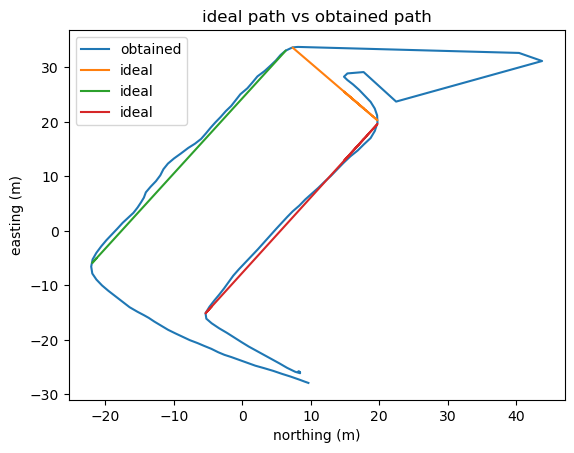

In [15]:
plt.plot(df_gps['northing'].tolist(), df_gps['easting'].tolist(), label='obtained')
# plt.plot(rl_x_plot, rl_y_true)
# plt.plot(tl_x_plot, tl_y_true)
# plt.plot(bl_x_plot, bl_y_true)

# plt.plot(ll_x_plot, ll_y_plot, label='ideal')
plt.plot(rl_x_plot, rl_y_plot, label='ideal')
plt.plot(tl_x_plot, tl_y_plot, label='ideal')
plt.plot(bl_x_plot, bl_y_plot, label='ideal')

plt.xlabel('northing (m)')
plt.ylabel('easting (m)')
plt.legend()
plt.title('ideal path vs obtained path')

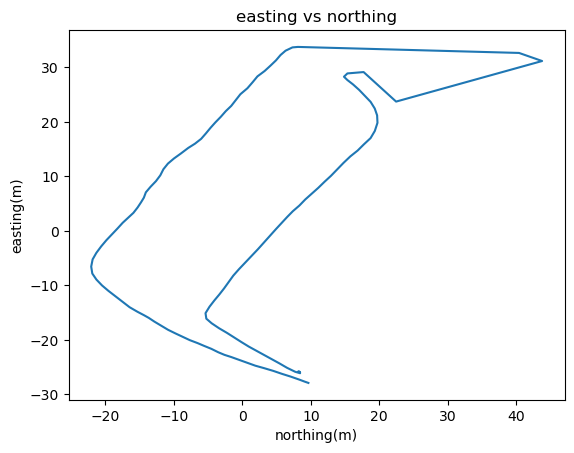

In [16]:
plot_graph('northing', 'easting', 'm', 'm')

In [17]:
def get_rmse(ys, y_ideals):
    rmse = 0
    for i in range(len(ys)):
        rmse += np.sqrt(np.square(ys[i] - y_ideals[i]).mean())
    rmse /= len(ys)
    return rmse

In [18]:
ys = [rl_y_plot, tl_y_plot, bl_y_plot]
y_ideals = [rl_y_true, tl_y_true, bl_y_true]
get_rmse(ys, y_ideals)

6.937809418651786

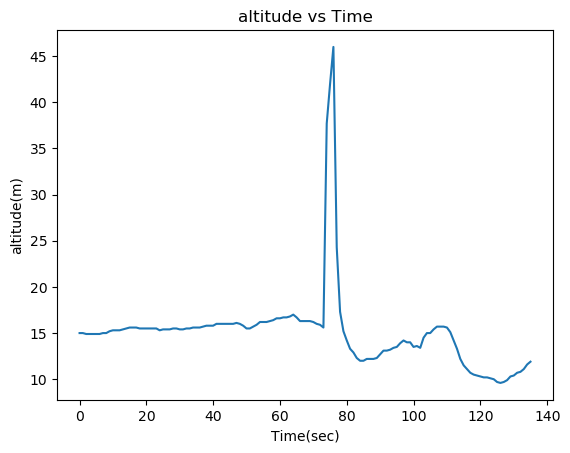

In [19]:
plot_graph('Time', 'altitude', 'sec', 'm')

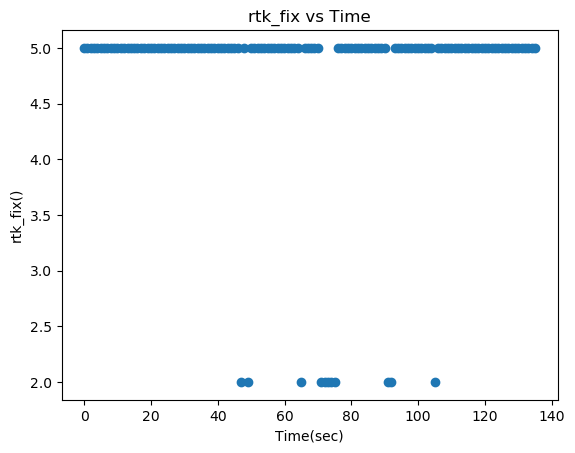

In [20]:
plot_graph('Time', 'rtk_fix', 'sec', '', True)